In [1]:
#@title Imports
import jax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns 

# The default of float16 can lead to discrepancies between outputs of
# the compiled model and the RASP program.
jax.config.update('jax_default_matmul_precision', 'float32')

from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp

In [2]:
#@title Plotting functions
def tidy_label(label, value_width=5):
  if ':' in label:
    label, value = label.split(':')
  else:
    value = ''
  return label + f":{value:>{value_width}}"


def add_residual_ticks(model, value_width=5, x=False, y=True):
  if y:
    plt.yticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            fontsize=20,
    )
  if x:
    plt.xticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            rotation=90,
            fontsize=20,
    )


def plot_computation_trace(model,
                           input_labels,
                           residuals_or_outputs,
                           add_input_layer=False,
                           figsize=(12, 9)):
  fig, axes = plt.subplots(nrows=1, ncols=len(residuals_or_outputs), figsize=figsize, sharey=True)
  value_width = max(map(len, map(str, input_labels))) + 1

  for i, (layer, ax) in enumerate(zip(residuals_or_outputs, axes)):
    plt.sca(ax)
    plt.pcolormesh(layer[0].T, vmin=0, vmax=1)
    if i == 0:
      add_residual_ticks(model, value_width=value_width)
    plt.xticks(
        np.arange(len(input_labels))+0.5,
        input_labels,
        rotation=90,
        fontsize=20,
    )
    if add_input_layer and i == 0:
      title = 'Input'
    else:
      layer_no = i - 1 if add_input_layer else i
      layer_type = 'Attn' if layer_no % 2 == 0 else 'MLP'
      title = f'{layer_type} {layer_no // 2 + 1}'
    plt.title(title, fontsize=20)


def plot_residuals_and_input(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the residual stream at each layer."""
  model_out = model.apply(inputs)
  residuals = np.concatenate([model_out.input_embeddings[None, ...],
                              model_out.residuals], axis=0)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=residuals,
      add_input_layer=True,
      figsize=figsize)


def plot_layer_outputs(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the outputs of each layer."""
  model_out = model.apply(inputs)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=model_out.layer_outputs,
      add_input_layer=False,
      figsize=figsize)


In [3]:
#@title Define RASP programs
def get_program(program_name, max_seq_len):
  """Returns RASP program and corresponding token vocabulary."""
  if program_name == "length":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_length()
  elif program_name == "frac_prevs":
    vocab = {"a", "b", "c", "x"}
    program = lib.make_frac_prevs((rasp.tokens == "x").named("is_x"))
  elif program_name == "dyck-2":
    vocab = {"(", ")", "{", "}"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}"])
  elif program_name == "dyck-3":
    vocab = {"(", ")", "{", "}", "[", "]"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}", "[]"])
  elif program_name == "sort":
    vocab = {i for i in range(1, max_seq_len + 1)}
    program = lib.make_sort(
        rasp.tokens, rasp.tokens, max_seq_len=max_seq_len, min_key=1)
  elif program_name == "sort_unique":
    vocab = {i for i in range(1, max_seq_len + 1)}
    program = lib.make_sort_unique(rasp.tokens, rasp.tokens)
  elif program_name == "hist":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_hist()
  elif program_name == "sort_freq":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_sort_freq(max_seq_len=max_seq_len)
  elif program_name == "pair_balance":
    vocab = {"(", ")"}
    program = lib.make_pair_balance(
        sop=rasp.tokens, open_token="(", close_token=")")
  else:
    raise NotImplementedError(f"Program {program_name} not implemented.")
  return program, vocab

In [7]:
#@title: Assemble model
program_name = "sort_unique"  #@param ["length", "frac_prevs", "dyck-2", "dyck-3", "sort", "sort_unique", "hist", "sort_freq", "pair_balance"]
max_seq_len = 10 #@param {label: "Test", type: "integer"}

program, vocab = get_program(program_name=program_name,
                             max_seq_len=max_seq_len)

print(f"Compiling...")
print(f"   Program: {program_name}")
print(f"   Input vocabulary: {vocab}")
print(f"   Context size: {max_seq_len}")

assembled_model = compiling.compile_rasp_to_model(
      program=program,
      vocab=vocab,
      max_seq_len=max_seq_len,
      causal=False,
      compiler_bos="bos",
      compiler_pad="pad",
      mlp_exactness=100)

print("Done.")

Compiling...
   Program: sort_unique
   Input vocabulary: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
   Context size: 10
Done.


In [8]:
#@title Forward pass
assembled_model.apply(["bos", 3, 4, 1, 7, 2, 6, 5, 8, 9, 10]).decoded

['bos', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

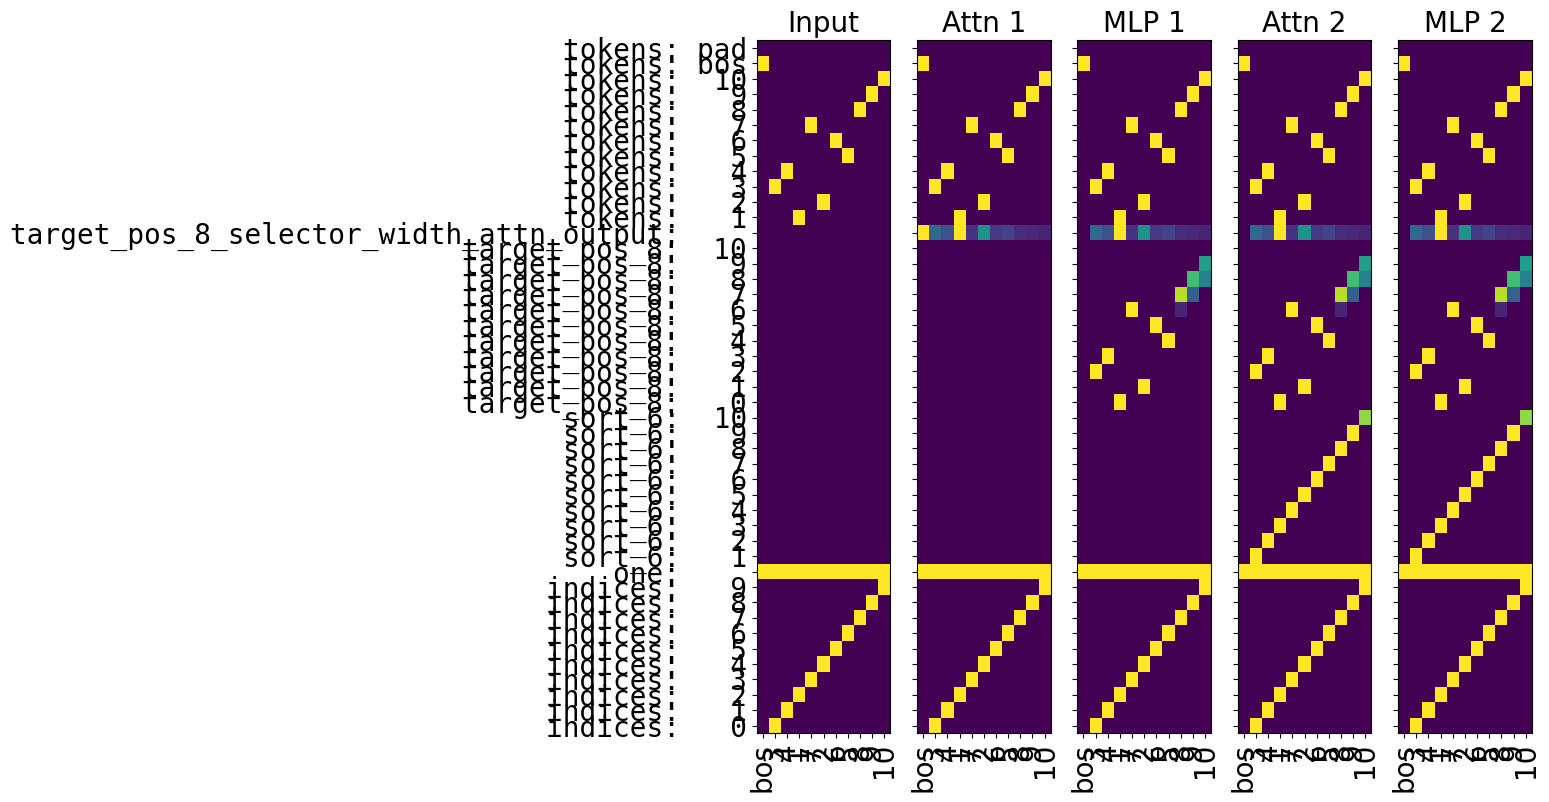

In [9]:
#@title Plot residual stream
plot_residuals_and_input(
  model=assembled_model,
  inputs=["bos", 3, 4, 1, 7, 2, 6, 5, 8, 9, 10],
  figsize=(10, 9)
)

## Make dataset of examples

In [10]:
max_seq_len = 10
program_name = 'sort_unique'

def get_permutations(nums): 
    if len(nums) == 1:
        return [nums[:]]
        
    res = []

    for _ in range(len(nums)):
        n = nums.pop(0)
        perms = get_permutations(nums)

        for p in perms:
            p.append(n)
        
        res.extend(perms)
        nums.append(n)
    
    return res

dataset = get_permutations([i for i in range(1, max_seq_len + 1)])
dataset = [['bos'] + list(d) for d in dataset]

In [11]:
# assert accuracy
# collect activations

# sample 1000 from dataset
np.random.seed(0)
np.random.shuffle(dataset)
dataset = dataset[:1000]

program, vocab = get_program(program_name=program_name,
                             max_seq_len=max_seq_len)

print(f"Compiling...")
print(f"   Program: {program_name}")
print(f"   Input vocabulary: {vocab}")
print(f"   Context size: {max_seq_len}")

assembled_model = compiling.compile_rasp_to_model(
program=program,
vocab=vocab,
max_seq_len=max_seq_len,
causal=False,
compiler_bos="bos",
compiler_pad="pad",
mlp_exactness=100)

residuals = []
layer_outputs = []

for d in tqdm(dataset): 
      output = assembled_model.apply(d)
      residuals.append(output.residuals)
      layer_outputs.append(output.layer_outputs)
      decoded = output.decoded[1:]
      check = sorted(d[1:])
      assert decoded == check, f"Expected {check}, got {decoded}"

Compiling...
   Program: sort_unique
   Input vocabulary: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
   Context size: 10


100%|██████████| 1000/1000 [00:37<00:00, 26.39it/s]


In [12]:
layer_outputs = np.array(layer_outputs).squeeze()
residuals = np.array(residuals).squeeze()

residuals.shape

(1000, 4, 11, 45)

In [18]:
post_attn_1 = residuals[:, 0].squeeze()

# combine dim 0 and 1
post_attn_1 = np.concatenate(post_attn_1, axis=0)

print(post_attn_1.shape)

(11000, 45)


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch_dataset = torch.tensor(post_attn_1, dtype=torch.float32)
batch_size = 32

train_set, test_set = torch.utils.data.random_split(post_attn_1, [5500, 5500])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [24]:
class AutoEncoder(nn.Module): 
    def __init__(self, input_size, hidden_size, sparsity_penalty):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.sparsity_penalty = sparsity_penalty

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = encoded @ self.encoder.weight

        return encoded, decoded
    
    def loss(self, x): 

        encoded, decoded = self.forward(x)
        recon_loss = nn.MSELoss()(decoded, x)
        sparsity = torch.abs(encoded).mean()
        num_nonzero = torch.sum(encoded != 0) // encoded.shape[0]
        loss = recon_loss + self.sparsity_penalty * sparsity

        return loss, recon_loss, sparsity, num_nonzero, encoded

ae = AutoEncoder(torch_dataset.shape[1], 4 * torch_dataset.shape[1], 0.1)
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

epochs = 100

losses, recon_losses, sparsities, nnzs = [], [], [], []
test_losses, test_recon_losses, test_sparsities, test_nnzs, test_acts = [], [], [], [], []

pbar = tqdm(range(epochs))
for epoch in pbar:
    for batch in train_loader:
        optimizer.zero_grad()
        loss, recon_loss, sparsity, nnz, _ = ae.loss(batch)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        recon_losses.append(recon_loss.item())
        sparsities.append(sparsity.item())
        nnzs.append(nnz.item())

    with torch.no_grad():
        for batch in test_loader:
            test_loss, test_recon_loss, test_sparsity, test_nnz, test_act = ae.loss(batch)
            test_losses.append(test_loss.item())
            test_recon_losses.append(test_recon_loss.item())
            test_sparsities.append(test_sparsity.item())
            test_nnzs.append(test_nnz.item())
            test_acts.append(test_act.detach().cpu())

    pbar.set_description(f"Loss: {loss.item():.3f}, Recon: {recon_loss.item():.3f}, Sparsity: {sparsity.item():.3f}, NNZ: {nnz.item():.3f}")

Loss: 0.000, Recon: 0.000, Sparsity: 0.004, NNZ: 2.000: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


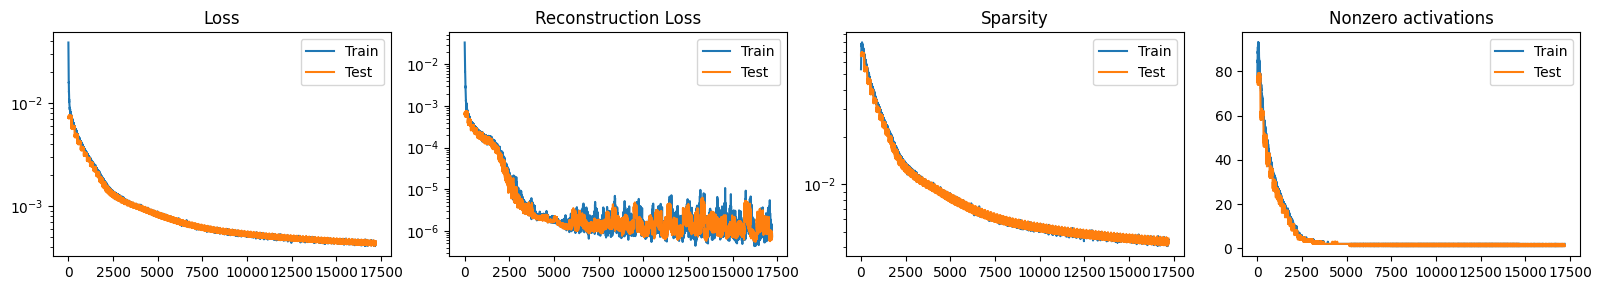

In [25]:
# get 3 x 1 grid of plots 
# loss, recon, sparsity

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

axes[0].plot(losses, label='Train')
axes[0].plot(test_losses, label='Test')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(recon_losses, label='Train')
axes[1].plot(test_recon_losses, label='Test')
axes[1].set_title('Reconstruction Loss')
axes[1].legend()

axes[2].plot(sparsities, label='Train')
axes[2].plot(test_sparsities, label='Test')
axes[2].set_title('Sparsity')
axes[2].legend()

axes[3].plot(nnzs, label='Train')
axes[3].plot(test_nnzs, label='Test')
axes[3].set_title('Nonzero activations')
axes[3].legend()

axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()


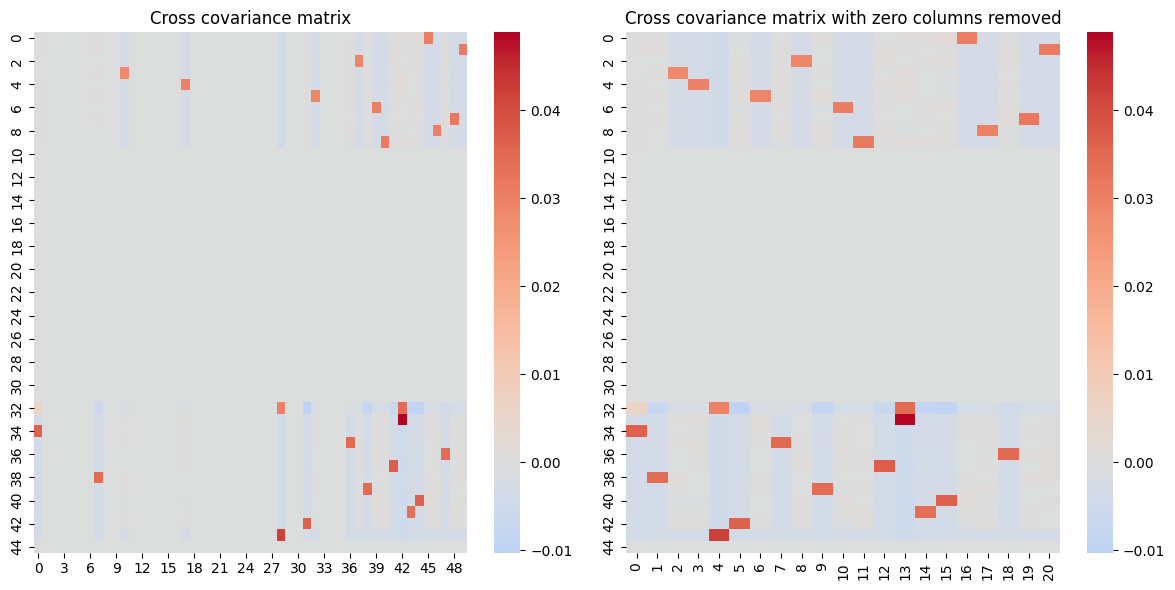

In [26]:
# how many neurons are active? 

test_acts = []
nnz_idxs = set()

with torch.no_grad():
    for batch in test_loader:
        test_loss, test_recon_loss, test_sparsity, test_nnz, test_act = ae.loss(batch)
        idxs = torch.nonzero(test_act).flatten()
        nnz_idxs.update(idxs.tolist())
        test_acts.append(test_act.detach().cpu())

nnz_idxs = list(nnz_idxs)
test_acts = torch.cat(test_acts, dim=0)
test_acts = test_acts[:, nnz_idxs]
orig_features = torch.tensor(test_set.dataset[test_set.indices])

# get cross covariance matrix between neurons
test_acts_centered = test_acts - test_acts.mean(dim=0, keepdim=True)
orig_features_centered = orig_features - orig_features.mean(dim=0, keepdim=True)

cross_cov_mat = orig_features_centered.T @ test_acts_centered / (test_acts.shape[0] - 1)

num_nonzero = torch.sum(cross_cov_mat != 0, dim=0)
nonzero_idxs = torch.nonzero(num_nonzero).flatten()
nnz_cross_cov_mat = cross_cov_mat[:, nonzero_idxs]

# put both heatmaps side by side 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.heatmap(cross_cov_mat, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Cross covariance matrix')

sns.heatmap(nnz_cross_cov_mat, cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title('Cross covariance matrix with zero columns removed')

plt.tight_layout()
plt.show()

## Using anthropic's autoencoder setup

In [27]:
class AnthropicAutoEncoder(nn.Module): 

    def __init__(self, input_dim, hidden_dim, l1_coeff): 

        super(AnthropicAutoEncoder, self).__init__()
        stdv = 1. / np.sqrt(input_dim)
        # init with uniform distribution
        self.W_enc = nn.Parameter(torch.empty(input_dim, hidden_dim).uniform_(-stdv, stdv))
        self.W_dec = nn.Parameter(torch.empty(hidden_dim, input_dim).uniform_(-stdv, stdv))
        self.b_enc = nn.Parameter(torch.empty(hidden_dim).uniform_(-stdv, stdv))
        self.b_dec = nn.Parameter(torch.empty(input_dim).uniform_(-stdv, stdv))

        self.l1_coeff = l1_coeff
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

    def forward(self, x): 

        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        encoded = acts @ self.W_dec + self.b_dec
        l2_loss = nn.MSELoss()(encoded, x)
        l1_loss = (acts.float().abs().mean())
        loss = l2_loss + l1_loss * self.l1_coeff
        nnz = torch.sum(acts != 0) // acts.shape[0]
        return loss, l2_loss, l1_loss, nnz, encoded, acts

    @torch.no_grad()
    def make_decoder_weights_and_grad_unit_norm(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj
        self.W_dec.data = W_dec_normed

anthropic_ae = AnthropicAutoEncoder(torch_dataset.shape[1], 4 * torch_dataset.shape[1], 0.1)
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

epochs = 100

losses, recon_losses, sparsities, nnzs = [], [], [], []
test_losses, test_recon_losses, test_sparsities, test_nnzs, test_acts = [], [], [], [], []

pbar = tqdm(range(epochs))
for epoch in pbar:
    for batch in train_loader:
        optimizer.zero_grad()
        loss, recon_loss, sparsity, nnz, _, _ = anthropic_ae(batch)
        loss.backward()
        # anthropic_ae.make_decoder_weights_and_grad_unit_norm()
        optimizer.step()

        losses.append(loss.item())
        recon_losses.append(recon_loss.item())
        sparsities.append(sparsity.item())
        nnzs.append(nnz.item())

    with torch.no_grad():
        for batch in test_loader:
            test_loss, test_recon_loss, test_sparsity, test_nnz, _, test_act = anthropic_ae(batch)
            test_losses.append(test_loss.item())
            test_recon_losses.append(test_recon_loss.item())
            test_sparsities.append(test_sparsity.item())
            test_nnzs.append(test_nnz.item())
            test_acts.append(test_act.detach().cpu())

    pbar.set_description(f"Loss: {loss.item():.3f}, Recon: {recon_loss.item():.3f}, Sparsity: {sparsity.item():.3f}, NNZ: {nnz.item():.3f}")

Loss: 0.131, Recon: 0.123, Sparsity: 0.085, NNZ: 92.000: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


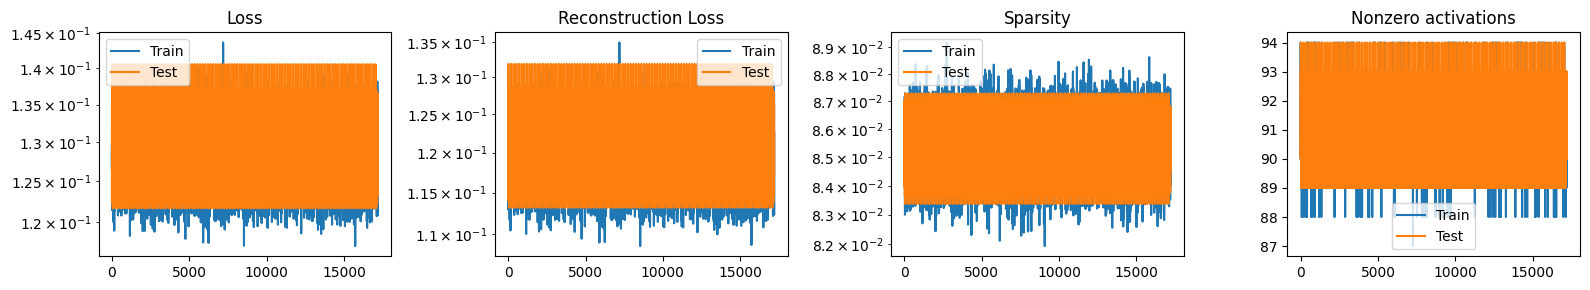

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

axes[0].plot(losses, label='Train')
axes[0].plot(test_losses, label='Test')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(recon_losses, label='Train')
axes[1].plot(test_recon_losses, label='Test')
axes[1].set_title('Reconstruction Loss')
axes[1].legend()

axes[2].plot(sparsities, label='Train')
axes[2].plot(test_sparsities, label='Test')
axes[2].set_title('Sparsity')
axes[2].legend()

axes[3].plot(nnzs, label='Train')
axes[3].plot(test_nnzs, label='Test')
axes[3].set_title('Nonzero activations')
axes[3].legend()

axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()


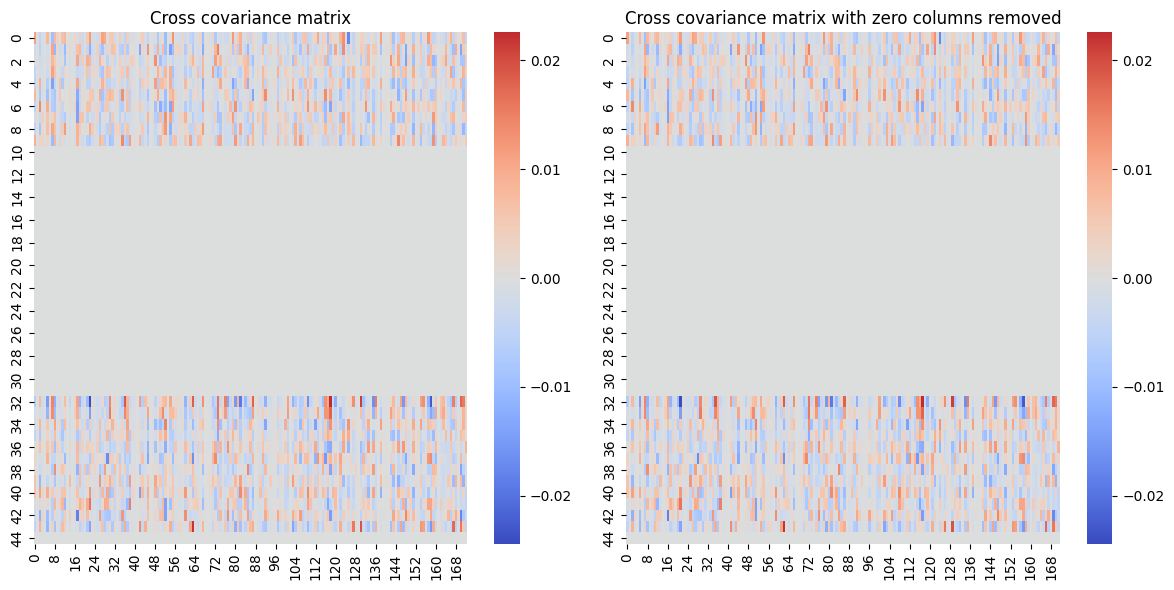

In [29]:
# how many neurons are active? 

test_acts = []
nnz_idxs = set()

with torch.no_grad():
    for batch in test_loader:
        test_loss, test_recon_loss, test_sparsity, test_nnz, _, test_act = anthropic_ae(batch)
        idxs = torch.nonzero(test_act).flatten()
        nnz_idxs.update(idxs.tolist())
        test_acts.append(test_act.detach().cpu())

nnz_idxs = list(nnz_idxs)
test_acts = torch.cat(test_acts, dim=0)
test_acts = test_acts[:, nnz_idxs]
orig_features = torch.tensor(test_set.dataset[test_set.indices])

# get cross covariance matrix between neurons
test_acts_centered = test_acts - test_acts.mean(dim=0, keepdim=True)
orig_features_centered = orig_features - orig_features.mean(dim=0, keepdim=True)

cross_cov_mat = orig_features_centered.T @ test_acts_centered / (test_acts.shape[0] - 1)

num_nonzero = torch.sum(cross_cov_mat != 0, dim=0)
nonzero_idxs = torch.nonzero(num_nonzero).flatten()
nnz_cross_cov_mat = cross_cov_mat[:, nonzero_idxs]

# put both heatmaps side by side 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.heatmap(cross_cov_mat, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Cross covariance matrix')

sns.heatmap(nnz_cross_cov_mat, cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title('Cross covariance matrix with zero columns removed')

plt.tight_layout()
plt.show()